In [26]:
# ! pip install tensorflow
# ! pip install imbalanced-learn

# ! pip install imblearn

# ! pip install tensorflow==2.15.0

In [27]:
import warnings
warnings.filterwarnings("ignore")


%cd "D:\\Projects\\Mini_Projects\\Clickstream_customer_conversion"

D:\Projects\Mini_Projects\Clickstream_customer_conversion


In [28]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

In [29]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from imblearn.over_sampling import SMOTE

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow import keras
from tensorflow.keras.optimizers import Adam


import pickle

import os

import warnings
warnings.filterwarnings('ignore')

In [30]:
import xgboost as xgb
from xgboost import XGBRegressor

In [31]:
file_path = r'D:\Projects\Mini_Projects\Clickstream_customer_conversion\Research_Data\processed_data.csv'

In [32]:
data = pd.read_csv(file_path)
data.head()

,month,day,country,page1_main_category,colour,location,model_photography,page,avg_price,unique_products,browsing_depth,weekend,high_price_preference
0,6,22,29,3,13,1,2,2,46.928571,55,4,1,1
1,5,19,29,2,13,3,1,2,57.666667,4,2,0,1
2,7,15,29,3,9,5,1,1,38.900000,9,3,0,1
3,5,2,29,2,2,4,1,1,51.666667,5,2,0,0
4,6,9,29,2,9,5,1,2,52.333333,12,2,0,1


In [33]:
val = data.drop('high_price_preference', axis = 1)
tar = data['high_price_preference']

In [34]:
fs = XGBRegressor(n_estimators = 200, random_state = 90)

In [35]:
fs.fit(val, tar)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=200,
             n_jobs=None, num_parallel_tree=None, ...)

In [36]:
selected = pd.DataFrame({
    "col": val.columns,
    'sco':fs.feature_importances_
}).sort_values('sco', ascending = False).head(13)['col'].to_list()

In [37]:
val = val[selected]

tar = tar

In [38]:
tar.value_counts()

high_price_preference
0    80230
1    52149
Name: count, dtype: int64

In [39]:
smote = SMOTE()

In [40]:
os_val, os_tar = smote.fit_resample(val, tar)

In [41]:
os_tar.value_counts()

high_price_preference
1    80230
0    80230
Name: count, dtype: int64

In [42]:
x_train, x_test, tr_lab, ts_lab = train_test_split(os_val, os_tar, test_size = 0.2, random_state = 65)

# Logistic Regression

In [43]:

def build_logistic_regression(x_train, x_test, tr_lab, ts_lab):

    print("\n----------Building Logistic Regression----------")

    param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [500, 1000]
    }

    lr_model = LogisticRegression(random_state=65)

    random_search = RandomizedSearchCV(
        lr_model,
        param_grid,
        n_iter=20,
        cv=3,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )

    random_search.fit(x_train, tr_lab)

    best_model = random_search.best_estimator_

    ts_pred = best_model.predict(x_test)

    ts_probs = best_model.predict_proba(x_test)[:, 1]

    fpr, tpr, _ = roc_curve(ts_lab, ts_probs)

    auc_score = roc_auc_score(ts_lab, ts_probs)

    accuracy = accuracy_score(ts_lab, ts_pred)

    print(f"Best Parameters: {random_search.best_params_}")
    print(f"Best Cross-Validation Score: {random_search.best_score_:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(ts_lab, ts_pred))

    plt.figure(figsize=(5, 4))
    cm = confusion_matrix(ts_lab, ts_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='viridis')
    plt.title('Logistic Regression Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    plt.figure(figsize=(5, 4))
    plt.plot(fpr, tpr, label=f"ROC AUC = {auc_score:.2f}", color='blue')
    plt.plot([0, 1], [0, 1], linestyle='--', color='red')
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()
            
    return best_model

# Decision Tree

In [44]:
def build_decision_tree(x_train, x_test, tr_lab, ts_lab):

    print("\n----------Building Decision Tree----------")

    param_grid = {
        'max_depth': [None, 5, 10, 15, 20, 30],  
        'min_samples_split': [2, 5, 10, 15],  
        'min_samples_leaf': [1, 2, 4, 6],  
        'criterion': ['gini', 'entropy'],  
        'splitter': ['best', 'random']
    }

    dt_model = DecisionTreeClassifier(random_state=65)

    random_search = RandomizedSearchCV(
        dt_model,
        param_grid,
        n_iter=20,
        cv=3,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )

    random_search.fit(x_train, tr_lab)

    best_model = random_search.best_estimator_

    ts_pred = best_model.predict(x_test)

    ts_probs = best_model.predict_proba(x_test)[:, 1]

    fpr, tpr, _ = roc_curve(ts_lab, ts_probs)

    auc_score = roc_auc_score(ts_lab, ts_probs)
    
    accuracy = accuracy_score(ts_lab, ts_pred)

    print(f"Best Parameters: {random_search.best_params_}")
    print(f"Best Cross-Validation Score: {random_search.best_score_:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(ts_lab, ts_pred))

    plt.figure(figsize=(5, 4))
    cm = confusion_matrix(ts_lab, ts_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Decision Tree Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    plt.figure(figsize=(5, 4))
    plt.plot(fpr, tpr, label=f"ROC AUC = {auc_score:.2f}", color='blue')
    plt.plot([0, 1], [0, 1], linestyle='--', color='red')
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

    return best_model

# Random Forest

In [45]:

def build_random_forest(x_train, x_test, tr_lab, ts_lab):

    print('\n----------Building Random Forest----------')

    param_grid = {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2'], 
        'bootstrap': [True, False]
    }

    rf_model = RandomForestClassifier(random_state=65, warm_start=True, n_jobs=-1)

    random_search = RandomizedSearchCV(
        rf_model,
        param_grid,
        n_iter=20,
        cv=3,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )

    random_search.fit(x_train, tr_lab)

    best_model = random_search.best_estimator_

    ts_pred = best_model.predict(x_test)

    ts_probs = best_model.predict_proba(x_test)[:, 1]

    fpr, tpr, _ = roc_curve(ts_lab, ts_probs)

    auc_score = roc_auc_score(ts_lab, ts_probs)
    
    accuracy = accuracy_score(ts_lab, ts_pred)

    print(f"Best Parameters: {random_search.best_params_}")
    print(f"Best Cross-Validation Score: {random_search.best_score_:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(ts_lab, ts_pred))

    plt.figure(figsize=(5, 4))
    cm = confusion_matrix(ts_lab, ts_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='viridis')
    plt.title('Random Forest Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    plt.figure(figsize=(5, 4))
    plt.plot(fpr, tpr, label=f"ROC AUC = {auc_score:.2f}", color='blue')
    plt.plot([0, 1], [0, 1], linestyle='--', color='red')
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

    return best_model

# XG Boost

In [46]:
def build_xgboost(x_train, x_test, tr_lab, ts_lab):

    print('\n----------Building XGBoost----------')

    param_grid = {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'subsample': [0.7, 0.8, 1.0],
        'colsample_bytree': [0.7, 0.8, 1.0],  
        'gamma': [0, 0.1, 0.2], 
        'reg_lambda': [1, 2, 5]
    }

    xgb_model = xgb.XGBClassifier(random_state=65, tree_method="hist", gpu_id=0)

    random_search = RandomizedSearchCV (
        xgb_model,
        param_grid,
        n_iter = 10,  
        cv=3,  
        scoring='accuracy',
        n_jobs=1,
        verbose=1,
    )
    

    random_search.fit(x_train, tr_lab, eval_set=[(x_test, ts_lab)])

    best_model = random_search.best_estimator_

    ts_pred = best_model.predict(x_test)

    ts_probs = best_model.predict_proba(x_test)[:, 1]

    fpr, tpr, _ = roc_curve(ts_lab, ts_probs)

    auc_score = roc_auc_score(ts_lab, ts_probs)

    accuracy = accuracy_score(ts_lab, ts_pred)

    print(f"Best Parameters: {random_search.best_params_}")
    print(f"Best Cross-Validation Score: {random_search.best_score_:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(ts_lab, ts_pred))

    plt.figure(figsize=(5, 4))
    cm = confusion_matrix(ts_lab, ts_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('XGBoost Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    plt.figure(figsize=(5, 4))
    plt.plot(fpr, tpr, label=f"ROC AUC = {auc_score:.2f}", color='blue')
    plt.plot([0, 1], [0, 1], linestyle='--', color='red')
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

    return best_model

# Neural Networks

In [47]:
def build_neural_network(x_train, x_test, tr_lab, ts_lab):

    print("\n----------Building Neural Network----------")

    nn_model = Sequential([
        Dense(100, activation='relu', input_shape = (x_train.shape[1],)),
        Dropout(0.2), 
        Dense(75, activation= 'relu'),
        Dropout(0.2),
        Dense(50, activation='relu'), 
        Dropout(0.2),
        Dense(25, activation='relu'), 
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])

    nn_model.compile(optimizer = Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = nn_model.fit(x_train, tr_lab,
                        validation_split=0.2,  
                        epochs=50, 
                        batch_size=32,  
                        callbacks=[early_stopping],
                        verbose=1)
    
    ts_pred = (nn_model.predict(x_test) > 0.5).astype(int)

    ts_probs = nn_model.predict(x_test).flatten()

    fpr, tpr, _ = roc_curve(ts_lab, ts_probs)

    auc_score = roc_auc_score(ts_lab, ts_probs)

    accuracy = accuracy_score(ts_lab, ts_pred)

    print(f"Test Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(ts_lab, ts_pred))

    plt.figure(figsize=(5, 4))
    cm = confusion_matrix(ts_lab, ts_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='viridis')
    plt.title('Neural Network Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    plt.figure(figsize=(5, 4))
    plt.plot(fpr, tpr, label=f"ROC AUC = {auc_score:.2f}", color='blue')
    plt.plot([0, 1], [0, 1], linestyle='--', color='red')
    plt.xlabel("False Positive Rate (FPR)")
    plt.ylabel("True Positive Rate (TPR)")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

    return nn_model, history

# Comparing Models

In [48]:
def compare_models(models_dict, x_test, ts_lab):

    print("\n----------Comparing Models----------")

    results = {}

    for name, model in models_dict.items():
        if hasattr(model, "predict"):
            ts_probs = model.predict(x_test)
            ts_pred = (ts_probs > 0.5).astype(int)
        else:
            ts_pred = model.predict(x_test)

        accuracy = accuracy_score(ts_lab, ts_pred)
        auc_score = roc_auc_score(ts_lab, ts_pred)
        results[name] = {
            'Accuracy': accuracy,
            'Roc-Auc Score': auc_score,
            'Predictions': ts_pred
            
        }
    
    comparison = pd.DataFrame(results).T[['Accuracy', 'Roc-Auc Score']]

    comparison = comparison.sort_values('Accuracy', ascending = False)

    print(comparison)

    best_model_name = comparison.index[0]

    best_model = models_dict[best_model_name]

    plt.figure(figsize=(5, 4))
    sns.barplot(x=comparison.index, y='Accuracy', data=comparison)
    plt.title('Model Accuracy Comparison')
    plt.xlabel('Model')
    plt.ylabel('Accuracy')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return comparison, results, best_model, best_model_name

# Final Call

In [49]:
def run_all_models(x_train, x_test, tr_lab, ts_lab):

    lr_model = build_logistic_regression(x_train, x_test, tr_lab, ts_lab)
    dt_model = build_decision_tree(x_train, x_test, tr_lab, ts_lab)
    rf_model = build_random_forest(x_train, x_test, tr_lab, ts_lab)
    xgb_model = build_xgboost(x_train, x_test, tr_lab, ts_lab)
    nn_model, _ = build_neural_network(x_train, x_test, tr_lab, ts_lab)

    models = {
        'Logistic Regression': lr_model,
        'Decision Tree': dt_model,
        'Random Forest': rf_model,
        'XG Boost': xgb_model,
        'Neural Network': nn_model
    }

    comparison, results, best_model, best_model_name = compare_models(models, x_test, ts_lab)

    pickle_path = r'D:\Projects\Mini_Projects\Clickstream_customer_conversion\Pickles'

    os.makedirs(pickle_path, exist_ok=True)
    
    best_model_class = os.path.join(pickle_path, 'best_model_class.pkl')

    with open(best_model_class, 'wb') as file:
        pickle.dump(best_model, file)

    print(f"\nBest Model for Classification: {best_model_name} saved to 'best_model_class.pkl'")

    return models, comparison, results, best_model, best_model_name


----------Building Logistic Regression----------
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters: {'solver': 'liblinear', 'penalty': 'l1', 'max_iter': 500, 'C': 0.01}
Best Cross-Validation Score: 0.6931
Test Accuracy: 0.6951

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.67      0.69     16048
           1       0.69      0.72      0.70     16044

    accuracy                           0.70     32092
   macro avg       0.70      0.70      0.69     32092
weighted avg       0.70      0.70      0.69     32092



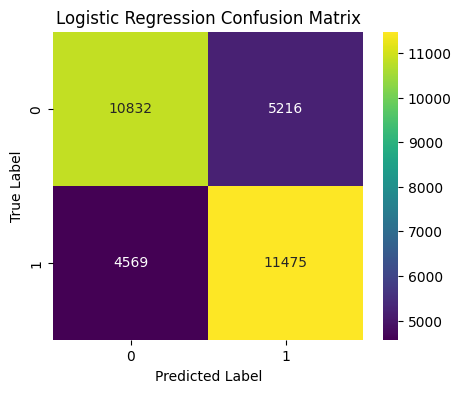

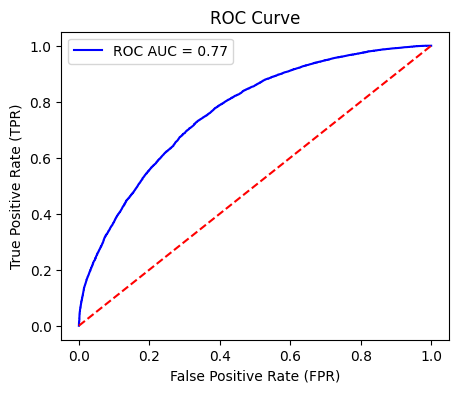


----------Building Decision Tree----------
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters: {'splitter': 'random', 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 20, 'criterion': 'gini'}
Best Cross-Validation Score: 0.9251
Test Accuracy: 0.9268

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.92      0.93     16048
           1       0.92      0.93      0.93     16044

    accuracy                           0.93     32092
   macro avg       0.93      0.93      0.93     32092
weighted avg       0.93      0.93      0.93     32092



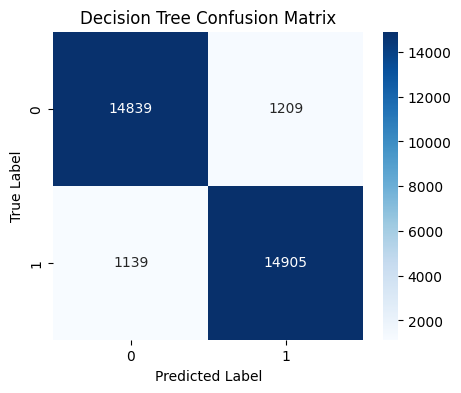

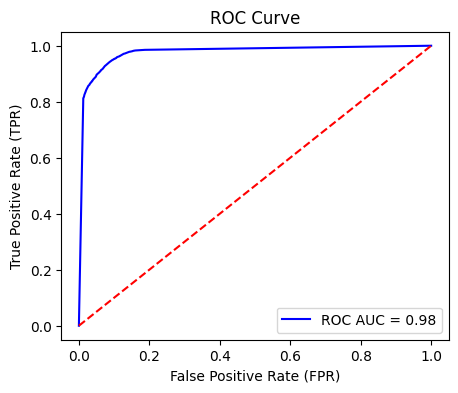


----------Building Random Forest----------
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 20, 'bootstrap': False}
Best Cross-Validation Score: 0.9325
Test Accuracy: 0.9341

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.92      0.93     16048
           1       0.92      0.95      0.94     16044

    accuracy                           0.93     32092
   macro avg       0.93      0.93      0.93     32092
weighted avg       0.93      0.93      0.93     32092



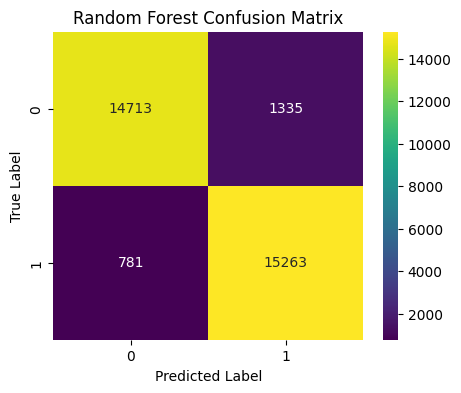

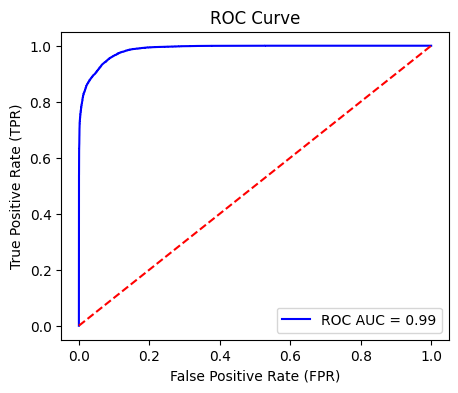


----------Building XGBoost----------
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[0]	validation_0-logloss:0.69011
[1]	validation_0-logloss:0.68715
[2]	validation_0-logloss:0.68128
[3]	validation_0-logloss:0.67783
[4]	validation_0-logloss:0.67456
[5]	validation_0-logloss:0.67211
[6]	validation_0-logloss:0.66683
[7]	validation_0-logloss:0.66465
[8]	validation_0-logloss:0.66130
[9]	validation_0-logloss:0.65813
[10]	validation_0-logloss:0.65524
[11]	validation_0-logloss:0.65132
[12]	validation_0-logloss:0.64778
[13]	validation_0-logloss:0.64370
[14]	validation_0-logloss:0.64014
[15]	validation_0-logloss:0.63623
[16]	validation_0-logloss:0.63205
[17]	validation_0-logloss:0.62829
[18]	validation_0-logloss:0.62419
[19]	validation_0-logloss:0.62250
[20]	validation_0-logloss:0.62026
[21]	validation_0-logloss:0.61577
[22]	validation_0-logloss:0.61362
[23]	validation_0-logloss:0.61032
[24]	validation_0-logloss:0.60679
[25]	validation_0-logloss:0.60477
[26]	validation_0-logloss:0

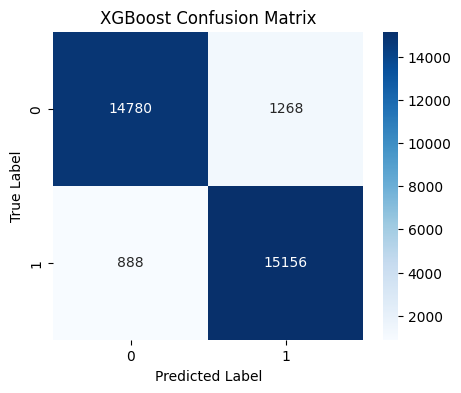

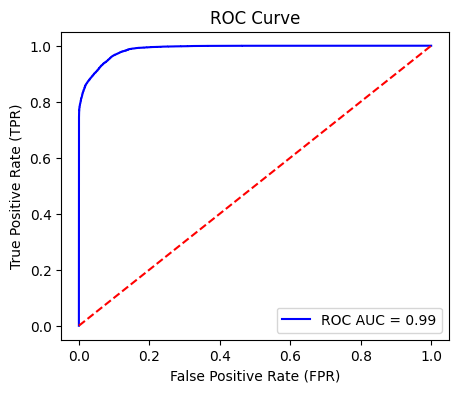


----------Building Neural Network----------
Epoch 1/50
3210/3210 [==============================] - 13s 4ms/step - loss: 0.6267 - accuracy: 0.6423 - val_loss: 0.5919 - val_accuracy: 0.6503
Epoch 2/50
3210/3210 [==============================] - 11s 3ms/step - loss: 0.5654 - accuracy: 0.6943 - val_loss: 0.5114 - val_accuracy: 0.7342
Epoch 3/50
3210/3210 [==============================] - 11s 3ms/step - loss: 0.5213 - accuracy: 0.7248 - val_loss: 0.4609 - val_accuracy: 0.7699
Epoch 4/50
3210/3210 [==============================] - 10s 3ms/step - loss: 0.4886 - accuracy: 0.7515 - val_loss: 0.4303 - val_accuracy: 0.7880
Epoch 5/50
3210/3210 [==============================] - 10s 3ms/step - loss: 0.4604 - accuracy: 0.7721 - val_loss: 0.4132 - val_accuracy: 0.8101
Epoch 6/50
3210/3210 [==============================] - 11s 3ms/step - loss: 0.4383 - accuracy: 0.7856 - val_loss: 0.3746 - val_accuracy: 0.8202
Epoch 7/50
3210/3210 [==============================] - 10s 3ms/step - loss: 0.4185 -

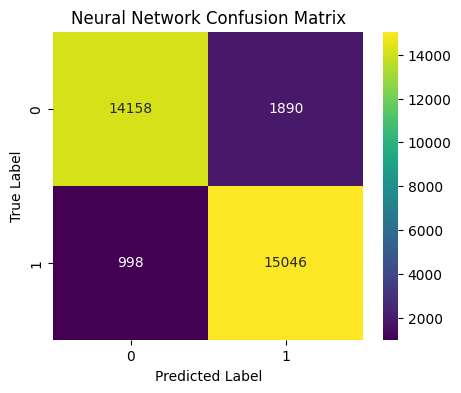

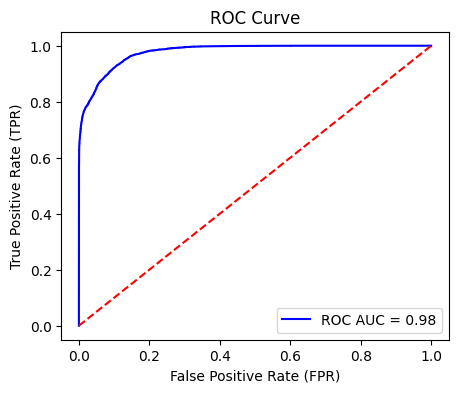


----------Comparing Models----------
1003/1003 [==============================] - 6s 5ms/step
                     Accuracy Roc-Auc Score
Random Forest        0.934065      0.934067
XG Boost             0.932818       0.93282
Decision Tree        0.926835      0.926836
Neural Network       0.910009      0.910012
Logistic Regression  0.695095      0.695098


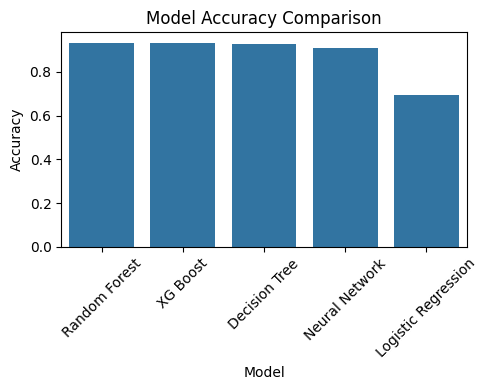


Best Model for Classification: Random Forest saved to 'best_model_class.pkl'


In [50]:
models, comparison, results, best_model, best_model_name = run_all_models(x_train, x_test, tr_lab, ts_lab)